# Sudoku Puzzle Extraction using OpenCV
See: https://medium.com/@neshpatel/solving-sudoku-part-ii-9a7019d196a2

First steps are to define a few utility functions for displaying and ploting things

In [2]:
import cv2
import numpy as np
from IPython.display import Image

In [3]:
import glob
glob.glob("../../Images/*")

['../../Images\\1.png',
 '../../Images\\1_500x500.png',
 '../../Images\\2.png',
 '../../Images\\3.png',
 '../../Images\\4.png',
 '../../Images\\5.png',
 '../../Images\\6.jpeg',
 '../../Images\\datasheet_sample.png',
 '../../Images\\sudoku-original.jpg',
 '../../Images\\test.jpg']

In [4]:
def showImg(title, image):
    cv2.imshow(title, image)
    
    # For Jupyter Notebook support
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [5]:
# See: https://gist.github.com/mineshpatel1/22e86200eee86ebe3e221343b26fc3f3#file-display_points-py
def display_points(in_img, points, radius=5, colour=(0, 0, 255)):
    """Draws circular points on an image."""
    img = in_img.copy()

    # Dynamically change to a colour image if necessary
    if len(colour) == 3:
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        elif img.shape[2] == 1:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    for point in points:
        img = cv2.circle(img, tuple(int(x) for x in point), radius, colour, -1)
    showImg("Display Points", img)
    return img

In [6]:
def plot_many_images(images, titles, rows=1, columns=2):
    """Plots each image in a given list in a grid format using Matplotlib."""
    for i, image in enumerate(images):
        plt.subplot(rows, columns, i+1)
        plt.imshow(image, 'gray')
        plt.title(titles[i])
        plt.xticks([]), plt.yticks([])  # Hide tick marks
    plt.show()

In [7]:
def display_rects(in_img, rects, colour=255):
    """Displays rectangles on the image."""
    img = in_img.copy()
    for rect in rects:
        img = cv2.rectangle(img, tuple(int(x) for x in rect[0]), tuple(int(x) for x in rect[1]), colour)
    showImg("Display Rectangles", img)
    return img

In [8]:
def show_digits(digits, colour=255):
    """Shows list of 81 extracted digits in a grid format"""
    rows = []
    with_border = [cv2.copyMakeBorder(img.copy(), 1, 1, 1, 1, cv2.BORDER_CONSTANT, None, colour) for img in digits]
    for i in range(9):
        row = np.concatenate(with_border[i * 9:((i + 1) * 9)], axis=1)
        rows.append(row)
    showImg("Show Digits", np.concatenate(rows))

In [112]:
def get_resized_img(img, threshold_dim=(500, 500)):
    width, height, channels = img.shape
    # If the image width and height do not exceed the specified threshold dimensions then resize accordingly
    if width < threshold_dim[0] and height < threshold_dim[1]:
        return cv2.resize(img, threshold_dim, interpolation=cv2.INTER_AREA)
    # Otherwise, return the original image
    return img   

## What Are We Looking For?
Let’s start with an photo of a Sudoku board

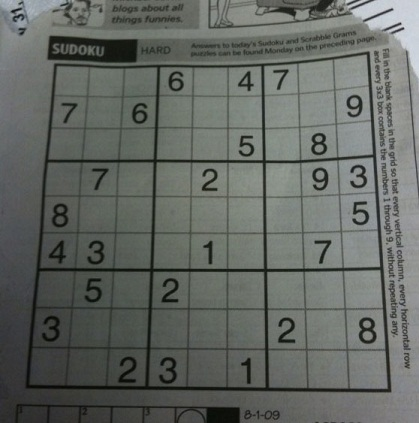

In [9]:
file_path = '../../Images/sudoku-original.jpg'
Image(file_path)

The board is at the center of the image and it’s really the only bit we’re interested in. The first thing we’ll want to do is separate the wheat from the chaff. The minimum information we need to do that are the four corners of the grid.

A human would trivially be able to identify the 4 corners of the grid and wouldn’t have to think about how they do it. Human brains handle this subconsciously. Sadly, this isn’t as easy for our technological troubadour and we will need to get a bit creative.

## How Computers Can See

Programming using images is quite complex and involves quite a lot of non-trivial mathematics. Luckily for us, there is an open source project, OpenCV, which has been made especially for these tasks. Luckier still, there are Python bindings for this project which Bernard will understand. Use ```pip install opencv-python``` to install the module and its dependencies. The following snippet reads an image from disk:

In [114]:
img = cv2.imread(file_path, cv2.IMREAD_COLOR)
print(type(img))
print(img.shape)
print(img)
showImg("Original Image", img)

<class 'numpy.ndarray'>
(423, 419, 3)
[[[175 171 160]
  [171 167 156]
  [180 171 162]
  ...
  [213 207 202]
  [213 207 202]
  [213 207 202]]

 [[175 171 160]
  [171 167 156]
  [178 171 162]
  ...
  [212 206 201]
  [212 206 201]
  [212 206 201]]

 [[172 168 157]
  [170 166 155]
  [173 166 157]
  ...
  [213 207 202]
  [213 207 202]
  [213 207 202]]

 ...

 [[ 43  43  43]
  [ 43  43  43]
  [ 39  41  41]
  ...
  [132 130 130]
  [135 133 133]
  [138 136 136]]

 [[ 46  46  46]
  [ 45  45  45]
  [ 41  43  43]
  ...
  [134 132 132]
  [136 134 134]
  [136 134 134]]

 [[ 48  48  48]
  [ 47  47  47]
  [ 42  44  44]
  ...
  [134 132 132]
  [134 132 132]
  [133 131 131]]]


In [110]:
# Assert that the image is at least 500x500 (if not then we have to resize it accordingly)
print("Original Dimensions: {}".format(img.shape))

Original Dimensions: (423, 419, 3)


In [113]:
resized = get_resized_img(img)
print("Resized Dimensions: {}".format(resized.shape))
showImg("Resized", resized)

Resized Dimensions: (500, 500, 3)


If we inspect the type of ```img``` we can see that it's actually a [Numpy array](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.ndarray.html). [Numpy](http://www.numpy.org/) is a Python module optimised for mathematic operations with matrices, and is certainly worth reading up on.

When we look at the content of ```img``` it appears at first glance to be somewhat incomprehensible. However when we use ```imshow``` to display the image on the screen it looks fine, so clearly the computer is comprehending it. The structure is actually quite simple: the [shape](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.shape.html) of the array is 2-D (according to height and width of the image) and each pixel is represented by a [tuple](https://www.tutorialspoint.com/python/python_tuples.htm) of 3 representing the [Blue-Green-Red (BGR)](https://en.wikipedia.org/wiki/RGB_color_model) color channels (it defaults to BGR, not RGB). Each channel is an integer between 0 and 255, so ```(0, 0, 0)``` is pure black and ```(255, 255, 255)``` is pure white. These are in a list of lists (2-D matrix) where the number of rows is the height of the image and the number of columns the width. If we choose to read the image as greyscale (use ```cv2.IMREAD_GRAYSCALE```), the color information is lost and each element simply becomes a single integer between 0 and 255, representing the brightness of the pixel.

Back to the task at hand, we need a method for identifying the grid in the center. We’re going to take advantage of the fact that the Sudoku grid will likely be the largest complete feature in the image, assuming the photographer was competent and not attempting some elaborate and unusually cruel deception. The grid in the middle is the only relevant information in the image, so we want to get the coordinates of the four corners of the grid in order to keep the grid and remove the nonsense.

There are functions we can use to try to detect the corners in the image, but before doing that we should process the image to improve the reliability of those operations. At the moment the image is mostly grays and each pixel as some grey value between 0 and 255. This is quite noisy for the operations we will perform for corner detection. A way to reduce this is by applying [binary thresholding](http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html#thresholding). These algorithms reduce an image to pure black and white, based on the contrast. Global thresholding (a.k.a, Binary thresholding) makes the split based on a threshold measured from the entire image, whereas adaptive thresholding calculates a threshold for each pixel in the image based on the mean value of surrounding pixels. This is useful when the contrast is uneven across parts of the image (e.g., shadows, etc.), which is pretty likely given the nature of human photographers.

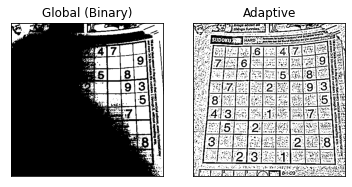

In [12]:
from matplotlib import pyplot as plt

img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

# Binary global threshold using a value of 127
ret, threshold1 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

# Binary adaptive threshold using 11 nearest neighbour pixels
threshold2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# showImg("Binary", threshold1)
# showImg("Adaptive", threshold2)
plot_many_images([threshold1, threshold2], ['Global (Binary)', 'Adaptive'])

We can also [blur](https://docs.opencv.org/3.1.0/d4/d13/tutorial_py_filtering.html) the image beforehand to reduce the noise picked up by the thresholding algorithm and [dilate](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html#dilation) the image to increase the thickness of the lines. It's necessary to preprocess the image in this way so that the computer can interpret pixels correctly to identify the sudoku puzzle.

In [22]:
def pre_process_image(img, skip_dilate=False, show_steps=False):
    """Uses a blurring function, adaptive thresholding and dilation to expose the main features of an image."""

    # Gaussian blur with a kernal size (height, width) of 9.
    # Note that kernal sizes must be positive and odd and the kernel must be square.
    gaussian = cv2.GaussianBlur(img.copy(), (9, 9), 0)

    # Adaptive threshold using 11 nearest neighbour pixels
    adaptive = cv2.adaptiveThreshold(gaussian, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # Invert colours, so gridlines have non-zero pixel values.
    # Necessary to dilate the image, otherwise will look like erosion instead.
    proc = cv2.bitwise_not(adaptive, adaptive)

    if not skip_dilate:
        # Dilate the image to increase the size of the grid lines.
#         kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]])
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        proc = cv2.dilate(proc, kernel, iterations=1)
    
    # Display images
    if show_steps:
        plot_many_images(
            [img, gaussian, adaptive, proc], 
            ['Original', 'Blur', 'Adaptive Threshold', 'Bitwise Not' if skip_dilate else 'Dilate'],
            rows=2, columns=2
        )

    return proc

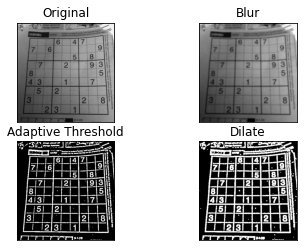

In [23]:
img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
processed = pre_process_image(img, skip_dilate=False, show_steps=True)
showImg("Processed", processed)

Compare the adaptive threshold images from the previous implementation that didn't use gaussian blurring to see the noise reduction when we use blurring: in this case less detail is more. Now we’ve reduced the complexity of the image considerably and have retained the feature of the image we are interested in, the only bit left is to have Bernard pick out the right shape. As the photographer is trying to take a photo of the Sudoku board, we can assume that it is the largest single feature in the image so long as the photographer isn’t an ignoramus.

Contours are a way of describing the boundaries of a shape that has the exact same intensity. Since we converted to binary tones using thresholding, we can use the [findContours](https://docs.opencv.org/3.3.0/d4/d73/tutorial_py_contours_begin.html) (algorithm) function to detect the contours in the image:

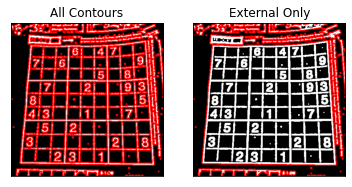

In [24]:
# Find the contours in the image
# cv2.RETR_TREE indicates how the contours will be retrieved:
# See: https://docs.opencv.org/trunk/d9/d8b/tutorial_py_contours_hierarchy.html
#
# cv2.CHAIN_APPROX_SIMPLE condenses the contour information, only storing the minimum number of points to describe
# the contour shape.
ext_contours, hier = cv2.findContours(processed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours, hier = cv2.findContours(processed.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

processed = cv2.cvtColor(processed, cv2.COLOR_GRAY2RGB)

# Draw all of the contours on the image in 2px red lines
all_contours = cv2.drawContours(processed.copy(), contours, -1, (255, 0, 0), 2)
external_only = cv2.drawContours(processed.copy(), ext_contours, -1, (255, 0, 0), 2)

# showImg("All Contours", all_contours)
# showImg("External Only", external_only)

plot_many_images([all_contours, external_only], ['All Contours', 'External Only'])

We can see that the contours describe the shapes we need incredibly well and that we only need the external contours to extract the board from the rest of the image. The function [cv2.contourArea](https://docs.opencv.org/trunk/dd/d49/tutorial_py_contour_features.html) is handy here as we can use it to easily get the largest feature in the image. We could use the [Ramer-Douglas-Peucker](https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm) algorithm to approximate the number of sides of the shape as well as this would allow us to filter for rectangular objects only. However, this limitation can give false negatives when folds in the page give the illusion that the grid had 5 sides instead of 4. As such it is more reliable to do away with this constraint and solely base the grid on the area.

Finally, getting the four corners of the grid is easy with the following logic:

* Top left point has the smallest ```x``` and smallest ```y``` coordinate, so minimize ```x + y```.
* Top right point has the largest ```x``` and the smallest ```y``` coordinate, so maximise ```x - y```.
* Bottom right point has the largest ```x``` and the largest ```y``` coordinate, so maximise ```x + y```.
* Bottom left point has the smallest ```x``` and the largest ```y``` coordinate, so minimise ```x - y```.

In [25]:
import operator

def find_corners_of_largest_polygon(img):
    """Finds the 4 extreme corners of the largest contour in the image."""
    contours, h = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
    polygon = contours[0]  # Largest image

    # Use of `operator.itemgetter` with `max` and `min` allows us to get the index of the point
    # Each point is an array of 1 coordinate, hence the [0] getter, then [0] or [1] used to get x and y respectively.

    # Bottom-right point has the largest (x + y) value
    # Top-left has point smallest (x + y) value
    # Bottom-left point has smallest (x - y) value
    # Top-right point has largest (x - y) value
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))

    # Return an array of all 4 points using the indices
    # Each point is in its own array of one coordinate
    return [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]

In [26]:
# Doing everything together now
img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
processed = pre_process_image(img)
corners = find_corners_of_largest_polygon(processed)
print(corners)
display_points(processed, corners)

[array([53, 63], dtype=int32), array([370,  51], dtype=int32), array([391, 393], dtype=int32), array([ 25, 389], dtype=int32)]


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

The next step is to cut out the part of the image we need and throw away the garbage. Notice that the photo was taken at a slight angle, so whilst our points map out a rectangle, it’s not a perfect square. Serendipitously, OpenCV has a function, ```warpPerspective```, that can do exactly what we want for handling this scenario. It is an implementation of the perspective transform equation, the non-vector form given by:

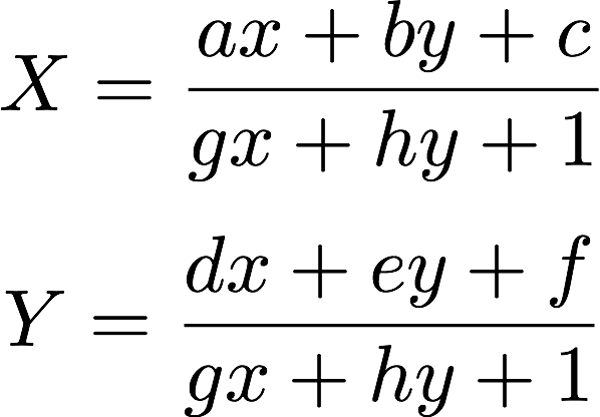

where ```X, Y, x, y``` are the sets of new and old coordinates respectively and the remaining variables are constants that we need to calculate. We can do this by solving multiple parallel equations mapping 4 coordinates from the original image onto the their new locations in the new image. This is easy to do with the four corners of the grid we obtained earlier, we just arrange the points as a square roughly the same size as the original grid. With a bit of elbow grease, this can be rearranged into a [matrix-vector product](https://wp.optics.arizona.edu/visualopticslab/wp-content/uploads/sites/52/2016/08/Lectures6_7.pdf) and any brave souls can look to [Criminisi et al.](http://www.robots.ox.ac.uk/~vgg/presentations/bmvc97/criminispaper/node1.html) for inspiration if they want to solve this by hand. I’d advise wearing harness and appropriate footwear and officially bear no responsibility for any injuries or fatalities incurred. In short, the ```warpPerspective``` function applies this algorithm and solves the equation:

In [27]:
def distance_between(p1, p2):
    """Returns the scalar distance between two points"""
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))


def crop_and_warp(img, crop_rect):
    """Crops and warps a rectangular section from an image into a square of similar size."""

    # Rectangle described by top left, top right, bottom right and bottom left points
    top_left, top_right, bottom_right, bottom_left = crop_rect[0], crop_rect[1], crop_rect[2], crop_rect[3]

    # Explicitly set the data type to float32 or `getPerspectiveTransform` will throw an error
    src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

    # Get the longest side in the rectangle
    side = max([
        distance_between(bottom_right, top_right),
        distance_between(top_left, bottom_left),
        distance_between(bottom_right, bottom_left),
        distance_between(top_left, top_right)
    ])

    # Describe a square with side of the calculated length, this is the new perspective we want to warp to
    dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

    # Gets the transformation matrix for skewing the image to fit a square by comparing the 4 before and after points
    m = cv2.getPerspectiveTransform(src, dst)

    # Performs the transformation on the original image
    return cv2.warpPerspective(img, m, (int(side), int(side)))

In [33]:
original = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
processed = pre_process_image(original)
corners = find_corners_of_largest_polygon(processed)
cropped = crop_and_warp(original, corners)
showImg("Cropped", cropped)

This is looking way better, the amount of irrelevant nonsense left in the image is sufficiently decreased and the warp transformation has made it look like we are viewing the board directly instead of at an angle. The next part is to identify the cells from the board. The obvious thing to do would be to divide up the grid into 81 evenly sized squares, since we have already warped it into a square. In this case, it pays to be obvious.

In [29]:
def infer_grid(img):
    """Infers 81 cell grid from a square image."""
    squares = []
    side = img.shape[:1]
    side = side[0] / 9
    for i in range(9):
        for j in range(9):
            p1 = (i * side, j * side)  # Top left corner of a bounding box
            p2 = ((i + 1) * side, (j + 1) * side)  # Bottom right corner of bounding box
            squares.append((p1, p2))
    return squares

In [34]:
original = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
processed = pre_process_image(original)
corners = find_corners_of_largest_polygon(processed)
cropped = crop_and_warp(original, corners)
squares = infer_grid(cropped)

display_rects(cropped, squares)

array([[255, 255, 255, ..., 255, 255, 255],
       [255,  75,  56, ...,  60,  95, 136],
       [255,  68,  46, ...,  51,  88, 138],
       ...,
       [255,  22,  16, ...,  42,  42,  88],
       [255,  36,  33, ...,  84,  86, 107],
       [255,  50,  50, ..., 128, 125, 128]], dtype=uint8)

Not bad, but not perfect either: a lot of cells have overlapping grid lines and the digits aren’t very well centered. This is all the kind of thing that doesn’t really bother your unconscious brain but this can be incredibly confusing to a computer. It is therefore our moral duty and obligation to simplify it further. Taking advantage of the fact that Sudoku grids are always simple and can only contain single digits in the middle of each box, we can implement a function that finds the largest connected pixel structure found when searching around the centre of each square. This is easier if we use similar pre-processing to when we were looking for the grid corners. If we are fortunate enough to find something, we can pull it out and center it in a new square of a fixed size, scaling it if we have to.

In [35]:
def cut_from_rect(img, rect):
    """Cuts a rectangle from an image using the top left and bottom right points."""
    return img[int(rect[0][1]):int(rect[1][1]), int(rect[0][0]):int(rect[1][0])]


def scale_and_centre(img, size, margin=0, background=0):
    """Scales and centres an image onto a new background square."""
    h, w = img.shape[:2]

    def centre_pad(length):
        """Handles centering for a given length that may be odd or even."""
        if length % 2 == 0:
            side1 = int((size - length) / 2)
            side2 = side1
        else:
            side1 = int((size - length) / 2)
            side2 = side1 + 1
        return side1, side2

    def scale(r, x):
        return int(r * x)

    if h > w:
        t_pad = int(margin / 2)
        b_pad = t_pad
        ratio = (size - margin) / h
        w, h = scale(ratio, w), scale(ratio, h)
        l_pad, r_pad = centre_pad(w)
    else:
        l_pad = int(margin / 2)
        r_pad = l_pad
        ratio = (size - margin) / w
        w, h = scale(ratio, w), scale(ratio, h)
        t_pad, b_pad = centre_pad(h)

    img = cv2.resize(img, (w, h))
    img = cv2.copyMakeBorder(img, t_pad, b_pad, l_pad, r_pad, cv2.BORDER_CONSTANT, None, background)
    return cv2.resize(img, (size, size))


def find_largest_feature(inp_img, scan_tl=None, scan_br=None):
    """
    Uses the fact the `floodFill` function returns a bounding box of the area it filled to find the biggest
    connected pixel structure in the image. Fills this structure in white, reducing the rest to black.
    """
    img = inp_img.copy()  # Copy the image, leaving the original untouched
    height, width = img.shape[:2]

    max_area = 0
    seed_point = (None, None)

    if scan_tl is None:
        scan_tl = [0, 0]

    if scan_br is None:
        scan_br = [width, height]

    # Loop through the image
    for x in range(scan_tl[0], scan_br[0]):
        for y in range(scan_tl[1], scan_br[1]):
            # Only operate on light or white squares
            if img.item(y, x) == 255 and x < width and y < height:  # Note that .item() appears to take input as y, x
                area = cv2.floodFill(img, None, (x, y), 64)
                if area[0] > max_area:  # Gets the maximum bound area which should be the grid
                    max_area = area[0]
                    seed_point = (x, y)

    # Colour everything grey (compensates for features outside of our middle scanning range
    for x in range(width):
        for y in range(height):
            if img.item(y, x) == 255 and x < width and y < height:
                cv2.floodFill(img, None, (x, y), 64)

    mask = np.zeros((height + 2, width + 2), np.uint8)  # Mask that is 2 pixels bigger than the image

    # Highlight the main feature
    if all([p is not None for p in seed_point]):
        cv2.floodFill(img, mask, seed_point, 255)

    top, bottom, left, right = height, 0, width, 0

    for x in range(width):
        for y in range(height):
            if img.item(y, x) == 64:  # Hide anything that isn't the main feature
                cv2.floodFill(img, mask, (x, y), 0)

            # Find the bounding parameters
            if img.item(y, x) == 255:
                top = y if y < top else top
                bottom = y if y > bottom else bottom
                left = x if x < left else left
                right = x if x > right else right

    bbox = [[left, top], [right, bottom]]
    return img, np.array(bbox, dtype='float32'), seed_point


def extract_digit(img, rect, size):
    """Extracts a digit (if one exists) from a Sudoku square."""

    digit = cut_from_rect(img, rect)  # Get the digit box from the whole square

    # Use fill feature finding to get the largest feature in middle of the box
    # Margin used to define an area in the middle we would expect to find a pixel belonging to the digit
    h, w = digit.shape[:2]
    margin = int(np.mean([h, w]) / 2.5)
    _, bbox, seed = find_largest_feature(digit, [margin, margin], [w - margin, h - margin])
    digit = cut_from_rect(digit, bbox)

    # Scale and pad the digit so that it fits a square of the digit size we're using for machine learning
    w = bbox[1][0] - bbox[0][0]
    h = bbox[1][1] - bbox[0][1]

    # Ignore any small bounding boxes
    if w > 0 and h > 0 and (w * h) > 100 and len(digit) > 0:
        return scale_and_centre(digit, size, 4)
    else:
        return np.zeros((size, size), np.uint8)


def get_digits(img, squares, size):
    """Extracts digits from their cells and builds an array"""
    digits = []
    img = pre_process_image(img.copy(), skip_dilate=True)
    for square in squares:
        digits.append(extract_digit(img, square, size))
    return digits

In [36]:
original = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
processed = pre_process_image(original)
corners = find_corners_of_largest_polygon(processed)
cropped = crop_and_warp(original, corners)
squares = infer_grid(cropped)
digits = get_digits(cropped, squares, 28)

# See https://gist.github.com/mineshpatel1/22e86200eee86ebe3e221343b26fc3f3#file-show_digits-py
show_digits(digits)

Easy peasy. Well no actually, that wasn’t easy at all, it was absurd amounts of work to get this far and Bernard still can’t even recognise the digits as anything but amorphous blobs. This is the crux of what makes this problem fascinating to me. It was trivial to write a program that could solve any puzzle of any difficulty in less than a second, puzzles that a certain type of a human might spend hours on for just for fun. However we’ve had to use a range of mathematical methods, a huge library of pre-programmed functions and a number of optimisation techniques, simply to be able to unreliably tell where the boxes are and if there’s stuff in them. This dichotomy is evidenced throughout life: catching a ball is easy, explaining precisely how you did it is not.

Your brain subconsciously performs image recognition for you via a series of neurons in the [visual ventral stream](https://en.wikipedia.org/wiki/Two-streams_hypothesis). It also does it horrendously quickly and vastly more reliably than the hackjob maths we programmed and it is able to do this because the neuron hierarchy is phenomenally complex. When this part of the brain is working properly you don’t notice it at all, but when it doesn’t you might start mistaking hats for wives. 

In [77]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
from PIL import Image
import os

In [93]:
def get_classified_digits(digits, stage_output):
    """
    Get region of images (roi) using training CNN for recognizing digits
    @param nparray digits the array representation of the extracted digits
    @param boolean stage_output whether to create staging output images for testing
    """
    model = load_model('../MNIST_Handwritten_Digit_Classifictation_CNN/final_model.h5')
    classified_digits = []
    i = 0
    for digit in digits:
        
        img = Image.fromarray(digit) 
        if stage_output:
            # Create staging dir if it does not exist

            if not os.path.exists('staging'):
                os.makedirs('staging')

            img.save('staging/cell_{}.png'.format(i))
        
        # Set classified digit to 0 if the cell is blank
        if not np.any(digit):
            classified_digits.append(0)
        else:
            # Otherwise, process digit accordingly
#             img = Image.fromarray(digit)  
            img_arr = img_to_array(img)

            # reshape into a single sample with 1 channel
            reshaped = img_arr.reshape(1, 28, 28, 1)

            # prepare pixel data
            float_data = reshaped.astype('float32')
            final_img = float_data / 255.0

            # predict the class
            digit = model.predict_classes(final_img)
            classified_digits.append(digit[0])
        
        i += 1
        
    return classified_digits


In [92]:
def get_grid_array(digits, stage_output=False):
    classified_digits = get_classified_digits(digits, stage_output=stage_output)
    row = []
    grid = []
    for i in range(len(classified_digits)):
        if i != 0 and (i % (len(classified_digits) / 9)) == 0:
            grid.append(row)
            row = []

        row.append(classified_digits[i])
    grid.append(row)
    return grid

In [100]:
def print_sudoku_puzzle(grid_array):
    # The character to determine formatting
    display = "";

    # Use the values from the sudokuPuzzle and write them to the respective cell using the txtFieldMap
    for row in range(9):
        display += "\n"
        for col in range(9):
            # Print out a divider every third line
            display += ("\t" if (col % 3 == 0) else " ") + str(grid_array[row][col]);
        display += "\n" if ((row + 1) % 3 == 0) else ""
            
    print(display)

In [98]:
grid_array = get_grid_array(digits)

In [101]:
print_sudoku_puzzle(grid_array)


	0 7 0	0 8 4	0 3 0
	0 0 0	7 0 3	5 0 0
	0 6 0	0 0 0	0 0 2

	6 0 0	0 0 0	2 0 3
	0 0 0	2 0 7	0 0 0
	0 0 5	0 0 0	0 0 7

	7 0 0	0 0 0	0 2 0
	0 0 8	9 0 7	0 0 0
	0 9 0	3 5 0	0 8 0

